In [1]:
# split train and test set of math symbols
import json
import random
import os

random.seed(777)

symbol_images_dir = 'symbol_images/'
terminals = ['+', '-', 'times', 'div', '!'] + list(map(str, list(range(10))))
sym_train_set = {}
sym_val_set = {}
sym_test_set = {}
for tok in terminals:
    imgs = os.listdir(symbol_images_dir + tok)
    random.shuffle(imgs)
    n_train = int(len(imgs) * 0.75)
    n_val = int(len(imgs) * 0.05)
    sym_train_set[tok] = sorted(imgs[:n_train])
    sym_val_set[tok] = sorted(imgs[n_train:n_train+n_val])
    sym_test_set[tok] = sorted(imgs[n_train+n_val:])
    print(tok, len(imgs))
json.dump(sym_train_set, open('sym_train.json', 'w'))
json.dump(sym_val_set, open('sym_val.json', 'w'))
json.dump(sym_test_set, open('sym_test.json', 'w'))

+ 25112
- 33997
times 3251
div 868
! 1300
0 6914
1 26520
2 26141
3 10909
4 7396
5 3545
6 3118
7 2909
8 3068
9 3737


In [2]:
from domain import SYM2PROG
import sys
sys.path.insert(0, "..")
sys.path.insert(0, "../semantics/dreamcoder")

from jointer import AST
import os
import random
from PIL import Image
import json
random.seed(777)

class Iterator:
    def __init__(self, l, shuffle=True):
        if shuffle: 
            random.shuffle(l)
        self.list = l
        self.current = -1
        self.shuffle = shuffle
    
    def next(self):
        self.current += 1
        if self.current == len(self.list):
            self.current = 0
            if self.shuffle:
                random.shuffle(self.list)
        return self.list[self.current]

splits = ['train', 'val', 'test']
split2sym = {}
for split in splits:
    sym_set = {k:Iterator(v) for k,v in json.load(open('sym_%s.json'%split)).items()}
    split2sym[split] = sym_set
    

def render_img(img_paths):
    images = [Image.open(symbol_images_dir + x) for x in img_paths]
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]
    return new_im

def generate_img_paths(tokens, sym_set):
    img_paths = []
    for tok in tokens:
        if tok == '*': tok = 'times'
        if tok == '/': tok = 'div'
        
        img_name = sym_set[tok].next()
        img_paths.append(os.path.join(tok, img_name))   
        
    return img_paths

In [3]:
min_num = 0
max_num = 10
num_list = list(map(str, range(min_num, max_num)))
nonzero_num_list = [x for x in num_list if x != '0']
op_list = ['+', '-', '*', '/']

print(num_list)
print(op_list)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
['+', '-', '*', '/']


In [4]:
def enumerate_expression(n_op):
    expressions = [[x] for x in num_list]
    for _ in range(n_op):
        new = []
        for expr in expressions:
            for op in op_list:
                if op == '!':
                    new.append(expr + [op])
                else:
                    for num in num_list:
                        new.append(expr + [op, num])
        expressions = new
    expressions = ["".join(expr) for expr in expressions]
    return expressions

def sample_expression(n_op, n_instances, min_value=0, max_value=float('inf')):
    def sample():
        expr = [random.choice(num_list)]
        for _ in range(n_op):
            selected_op = random.choice(op_list)
            expr.append(selected_op)
            if selected_op == '!':
                continue
            else:
                selected_num = random.choice(num_list)
                expr.append(selected_num)
        return "".join(expr)
    
    expressions = []
    while len(expressions) < n_instances:
        expr = sample()
        if expr in expressions:
            continue
        head = parse_expr(expr)
        res, res_all = eval_expr(expr, head)
        if res is not None:
            max_res = max(res_all)
            if max_res >= min_value and max_res <= max_value:
                expressions.append(expr)
    return list(expressions)

def generate_expression(n_op, n_instances, min_value=0, max_value=float('inf')):
    if n_op <= 3:
        expressions = []
        for expr in enumerate_expression(n_op):
            head = parse_expr(expr)
            res, res_all = eval_expr(expr, head)
            if res is not None:
                max_res = max(res_all)
                if max_res >= min_value and max_res <= max_value:
                    expressions.append(expr)
    else:
        assert n_instances is not None
        expressions = sample_expression(n_op, n_instances, min_value, max_value)
    random.shuffle(expressions)
    expressions = expressions[:n_instances]
    
    expressions = [(x, parse_expr(x)) for x in expressions]
    expressions = [(expr, head, *eval_expr(expr, head)) for expr, head in expressions]
    expressions = [expr for expr in expressions if expr[2] is not None]
    
    return expressions

from collections import namedtuple
Parse = namedtuple('Parse', 'sentence head')
def eval_expr(expr, head):
    ast = AST(Parse(expr, head), SYM2PROG)
    return ast.res(), ast.res_all()
    
def eval_expr_by_eval(expr):
    expr_for_eval = []
    for symbol in expr:
        if symbol == '!':
            expr_for_eval[-1] = 'math.factorial(' + expr_for_eval[-1] + ')'
        elif symbol == '/':
            expr_for_eval.append('//')
        else:
            expr_for_eval.append(symbol)
#     try:
#         res = eval("".join(expr_for_eval))
#     except OverflowError:
#         res = None
    res = eval("".join(expr_for_eval))
    return res

def parse_expr(expr):
    values = []
    operators = []
    priority = {'+': 0, '-': 0, '*': 1, '/': 1, '!': 2}
    arity = {'+': 2, '-': 2, '*': 2, '/': 2, '!': 1}

    head = [-1] * len(expr)
    for (i,sym) in enumerate(expr):
        if sym.isdigit():
            values.append(i)
        else:
            while len(operators) > 0 and priority[expr[operators[-1]]] >= priority[sym]:
                op = operators.pop()
                for _ in range(arity[expr[op]]):
                    head[values.pop()] = op
                values.append(op)
            operators.append(i)

    while len(operators) > 0:
        op = operators.pop()
        for _ in range(arity[expr[op]]):
            head[values.pop()] = op
        values.append(op)

    
    root_op = values.pop()
    head[root_op] = -1
    assert len(values) == 0

    return head

expr = '6/4+2!'
head = parse_expr(expr)
res = eval_expr(expr, head)
print(expr, res, head)

6/4+2! (4, [6, 2, 4, 4, 2, 2]) [1, 3, 1, -1, 5, 3]


In [5]:
expressions = generate_expression(2, 100000)
print(len(expressions))
print(len([x for x in expressions if x[2] != 0]))
print(len([x for x in expressions if x[2] == 0]))

15210
11317
3893


In [6]:
random.seed(12306)
max_op = 20
max_train_op = 5
n_train = int(5e3)
n_test = n_train
n_val = int(n_train / 10)
train_exprs = []
val_exprs = []
test_exprs = []

max_value_train = 100
max_value_test = 10000

for n_op in range(max_op + 1):
    if n_op > max_train_op:
        n_train = 0
    expressions = generate_expression(n_op, n_train + n_test, max_value=max_value_train)
    
    train_exprs.append(expressions[:n_train])
    val_exprs.append(expressions[:min(n_val, n_train)] + expressions[n_train:n_train+n_val])
    test_exprs.append(expressions[:n_train + n_test])
    
    expressions = generate_expression(n_op, n_test, min_value=max_value_train+1, max_value=max_value_test)
    val_exprs[-1].extend(expressions[:n_val])
    test_exprs[-1].extend(expressions)

    print(n_op, len(train_exprs[-1]), len(val_exprs[-1]), len(test_exprs[-1]))
    
split2exprs = {'train': train_exprs, 'val': val_exprs, 'test': test_exprs}
print([(k, sum([len(x) for x in v])) for k, v in split2exprs.items()])

0 10 10 10
1 390 390 390
2 5000 1308 10308
3 5000 1500 15000
4 5000 1500 15000
5 5000 1500 15000
6 0 1000 10000
7 0 1000 10000
8 0 1000 10000
9 0 1000 10000
10 0 1000 10000
11 0 1000 10000
12 0 1000 10000
13 0 1000 10000
14 0 1000 10000
15 0 1000 10000
16 0 1000 10000
17 0 1000 10000
18 0 1000 10000
19 0 1000 10000
20 0 1000 10000
[('train', 20400), ('val', 21208), ('test', 205708)]


In [7]:
split = 'train'
dataset = split2exprs[split][3]
print(len(dataset))
print(dataset[:5])

5000
[('2*9+6*0', [1, 3, 1, -1, 5, 3, 5], 18, [2, 18, 9, 18, 6, 0, 0]), ('2/5-4/1', [1, 3, 1, -1, 5, 3, 5], 0, [2, 1, 5, 0, 4, 4, 1]), ('0/4-6/6', [1, 3, 1, -1, 5, 3, 5], 0, [0, 0, 4, 0, 6, 1, 6]), ('8*9/5/5', [1, 3, 1, 5, 3, -1, 5], 3, [8, 72, 9, 15, 5, 3, 5]), ('0-3/4+6', [1, 5, 3, 1, 3, -1, 5], 6, [0, 0, 3, 1, 4, 6, 6])]


In [8]:
import math

split2dataset = {}
for split in splits:
    sym_set = split2sym[split]
    exprs = split2exprs[split]
    dataset = []
    idx = 0
    for n_op, expr_list in enumerate(exprs):
        if n_op == 0: n_instance = 100
        elif n_op == 1: n_instance = 10
        else: n_instance = 1
            
        if split == 'val':
            n_instance *= 0.1
        for e in expr_list:
            for _ in range(int(math.ceil(n_instance))):
                img_paths = generate_img_paths(e[0], sym_set)
                sample = {'id': '%s_%08d'%(split, idx), 'img_paths':img_paths, 
                      'expr': e[0], 'head': e[1], 'res': e[2], 'res_all': e[3]}
                idx += 1
                dataset.append(sample)
            if not isinstance(e[2], int):
                print(sample)
                input()
    split2dataset[split] = dataset
    print(split, len(dataset))

train 24900
val 21298
test 210208


In [16]:
from collections import Counter

dataset = split2dataset['train']
print(len([0 for x in dataset if x['res'] != 0]))
res_counts = Counter([x['res'] for x in dataset])
print(sorted(list(res_counts.items())))
print(random.sample(dataset, k=3))

dataset = split2dataset['val']
print(len([0 for x in dataset if x['res'] != 0]))
res_counts = Counter([x['res'] for x in dataset])
print(sorted(list(res_counts.items())))
print(len([0 for x in dataset if x['res'] <= 1000]))
print(len([0 for x in dataset if x['res'] > 1000]))
print(random.sample(dataset, k=3))

18501
[(0, 6399), (1, 1953), (2, 1381), (3, 1138), (4, 1111), (5, 1079), (6, 1075), (7, 1051), (8, 1094), (9, 1048), (10, 654), (11, 532), (12, 495), (13, 417), (14, 395), (15, 358), (16, 341), (17, 198), (18, 277), (19, 165), (20, 183), (21, 179), (22, 141), (23, 99), (24, 168), (25, 121), (26, 96), (27, 106), (28, 122), (29, 73), (30, 109), (31, 68), (32, 93), (33, 61), (34, 61), (35, 83), (36, 114), (37, 68), (38, 49), (39, 46), (40, 97), (41, 49), (42, 86), (43, 42), (44, 51), (45, 81), (46, 41), (47, 35), (48, 87), (49, 53), (50, 44), (51, 29), (52, 33), (53, 32), (54, 72), (55, 37), (56, 60), (57, 42), (58, 25), (59, 18), (60, 32), (61, 21), (62, 30), (63, 61), (64, 53), (65, 30), (66, 18), (67, 13), (68, 22), (69, 17), (70, 20), (71, 17), (72, 58), (73, 18), (74, 15), (75, 15), (76, 9), (77, 13), (78, 10), (79, 12), (80, 18), (81, 33), (82, 14), (83, 10), (84, 15), (85, 9), (86, 9), (87, 12), (88, 10), (89, 5), (90, 12), (91, 6), (92, 3), (93, 7), (94, 1), (95, 6), (96, 19), (98

train 24900 100
5/6/5/6 [1, 3, 1, 5, 3, -1, 5] 1


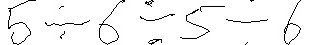

1-4+1-0+8-8 [1, 3, 1, 5, 3, 7, 5, 9, 7, -1, 9] 1


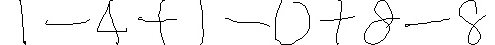

0+2*6 [1, -1, 3, 1, 3] 12


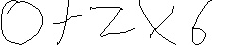

8*7/6+5+0 [1, 3, 1, 5, 3, 7, 5, -1, 7] 15


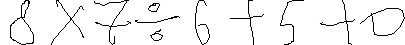

7/5+5/6*6 [1, 3, 1, -1, 5, 7, 5, 3, 7] 8


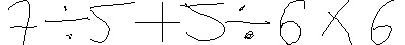

val 21298 9794
4/8-8/4 [1, 3, 1, -1, 5, 3, 5] 0


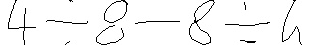

6/4/3*4*0*0/8-4-2/8+0+4+8+7*6 [1, 3, 1, 5, 3, 7, 5, 9, 7, 11, 9, 13, 11, 15, 13, 19, 17, 15, 17, 21, 19, 23, 21, 25, 23, -1, 27, 25, 27] 54


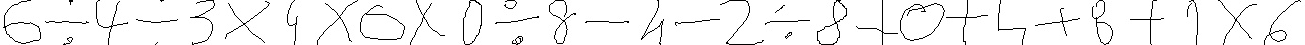

7+7/2+2-6/2*8*5-9+6*5/1/3+4+2*4+9-3 [1, 5, 3, 1, 3, 7, 5, 15, 9, 11, 9, 13, 11, 7, 13, 17, 15, 25, 19, 21, 19, 23, 21, 17, 23, 27, 25, 31, 29, 27, 29, 33, 31, -1, 33] 28


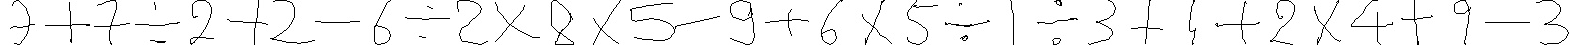

1*9/7-1*6*3*5*3+5*4 [1, 3, 1, 5, 3, 15, 7, 9, 7, 11, 9, 13, 11, 5, 13, -1, 17, 15, 17] 20


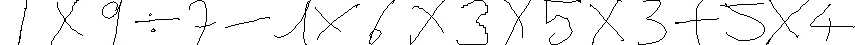

4/9-3*9*6-4/8*0+9+7*1*2+5 [1, 3, 1, 9, 5, 7, 5, 3, 7, 15, 11, 13, 11, 9, 13, 17, 15, 23, 19, 21, 19, 17, 21, -1, 23] 28


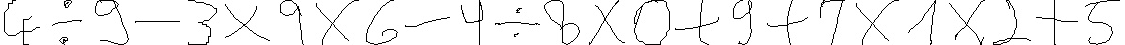

test 210208 9811
2/4*7-8*0+2*6-0*9+7*8*3/4/6-3*0-0 [1, 3, 1, 5, 3, 9, 7, 5, 7, 13, 11, 9, 11, 17, 15, 13, 15, 27, 19, 21, 19, 23, 21, 25, 23, 17, 25, 31, 29, 27, 29, -1, 31] 26


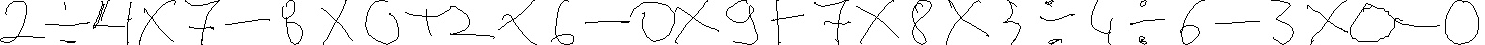

7*6*7-7/3-5 [1, 3, 1, 5, 3, 9, 7, 5, 7, -1, 9] 286


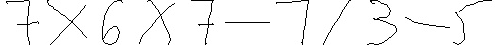

8-4*9*3*6+2+0*9-3-4+3+8-0/8-1*3/6+3-6-3 [1, 9, 3, 5, 3, 7, 5, 1, 7, 11, 9, 15, 13, 11, 13, 17, 15, 19, 17, 21, 19, 23, 21, 27, 25, 23, 25, 33, 29, 31, 29, 27, 31, 35, 33, 37, 35, -1, 37] 4


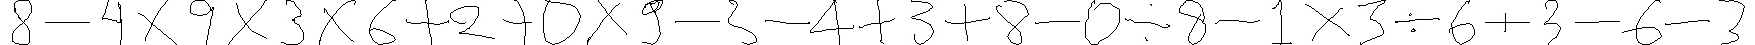

7*7-1+4*1+1-0-3+3/5*1-2+6/4*4+8+4*5+9 [1, 3, 1, 5, 3, 9, 7, 5, 7, 11, 9, 13, 11, 15, 13, 21, 17, 19, 17, 15, 19, 23, 21, 29, 25, 27, 25, 23, 27, 31, 29, 35, 33, 31, 33, -1, 35] 94


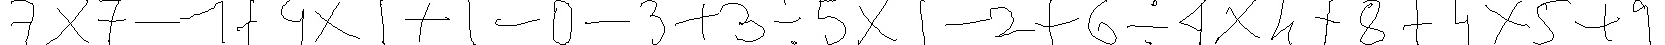

3+6*8*6+0 [1, 7, 3, 5, 3, 1, 5, -1, 7] 291


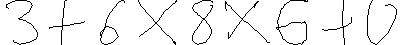

In [10]:
# Visualize data
import numpy as np
for split in splits:
    dataset = split2dataset[split]
    print(split, len(dataset), np.max([x['res'] for x in dataset]))
    for _ in range(5):
        sample = random.choice(dataset)
        img_paths = sample['img_paths']
        img = render_img(img_paths)
        print("".join(sample['expr']), sample['head'], sample['res'])
        display(img)

In [11]:
train_exprs = {x['expr'] for x in split2dataset['train']}
max_len_train = max([len(x) for x in train_exprs])
for split in ['val', 'test']:
    dataset = split2dataset[split]
    for sample in dataset:
        expr = sample['expr']
        if expr in train_exprs:
            evaluation = 1
        elif len(expr) <= max_len_train:
            max_value = max(sample['res_all'])
            if max_value <= max_value_train:
                evaluation = 2
            else:
                evaluation = 3
        else:
            max_value = max(sample['res_all'])
            if max_value <= max_value_train:
                evaluation = 4
            else:
                evaluation = 5
        sample['eval'] = evaluation

In [12]:
counts = sorted(Counter([x['eval'] for x in split2dataset['test']]).items())
total_count = sum([c for _, c in counts])
counts = [(k, round(v/total_count*100, 2)) for k, v in counts]
print(counts)
print(list({x['expr'] for x in split2dataset['test'] if x['eval'] == 3})[:10])

[(1, 11.85), (2, 9.51), (3, 7.28), (4, 35.68), (5, 35.68)]
['4*7*6/1/4+4', '5*7*3-3+3+3', '0-3-3*6*8', '2-4*9*5', '9*7*5/6/2', '6*7-8*7*9-4', '8*4*9-1', '3+5+5*7*9', '1-7*8*3', '9-0-5*2*7*3']


In [13]:
for split in splits:
    json.dump(split2dataset[split], open('expr_%s.json'%split, 'w'))

(45, 45)


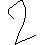

7/1/7-2 = -1.0


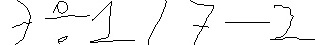

In [14]:
img = Image.open(symbol_images_dir + '2/2_849.jpg')
print(img.size)
display(img)

expr = '7/1/7-2'
img_paths = generate_img_paths(expr, sym_set=sym_set)
img = render_img(img_paths)
print(expr,'=', eval(expr))
display(img)